Notebook presenting basic implementation of Gillespie's first reaction method for simulating an SIR process on a network.

# Import libraries

In [3]:
%matplotlib inline

import numpy as np
import networkx as nx
import matplotlib.pylab as plt


#from numpy.random import seed, rand
from numpy.random import Generator, PCG64, SeedSequence

In [4]:
#--- Set up PRNG: ---
seed= 42                     # Set seed of PRNG state 
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed
print(f"PRNG: {rg.bit_generator}")

PRNG: <numpy.random._pcg64.PCG64 object at 0x7fd30efa55c0>


# SIR on network

## Define functions

In [5]:
##################################################################################################

def calculate_node_propensities(G, beta, mu):
    
    N                 = len(G)
    
    nx.set_node_attributes(G, 0., 'a')
    
    for i in range(N):
        #--- If node is susceptible calculate total propensity for infection: ---
        if G.nodes[i]['state'] == 0:
            # Get i's neighbors:
            neighbor_states = [G.nodes[j]['state'] for j in G.neighbors(i)] 

            # Total propensity from number of neighbors that are infectious:
            a_i = beta * np.sum([state==1 for state in neighbor_states])
            
            # Set node propensity and draw waiting time:
            if a_i > 0.:
                G.nodes[i]['a'] = a_i
                
                u_i = rg.random()
                G.nodes[i]['tau'] = -np.log(1. - u_i) / a_i
            
        #--- If node is infectious set propensity to mu: ---
        elif G.nodes[i]['state'] == 1:
            # Set node propensity:
            G.nodes[i]['a'] = mu    
            
            u_i = rg.random()
            G.nodes[i]['tau'] =  tau = -np.log(1. - u_i) / mu
    return()

##################################################################################################
##################################################################################################

def update_states(G, X):
    # State counts:
    t, S, I, R = X
    
    # Get waiting times for active channels from G:
    waiting_times, node_indices = list(nx.get_node_attributes(G, 'tau').values()), list(nx.get_node_attributes(G, 'tau'))
        
    # Find minimal waiting time and corresponding node index:
    tau = np.min(waiting_times)
    i_0 = np.where(waiting_times == tau)[0][0]
    i_selected = node_indices[i_0] 
    
    # Add waiting time to wall time:
    t += tau
    
    #--- Update waiting times for remaining nodes: ---
    node_indices.pop(i_0)
    
    for j in node_indices:
        G.nodes[j]['tau'] -= tau

    #===== Update network state: =====
    state_before = G.nodes[i_selected]['state']

    #--- If state_before was S, update to I: ---
    if state_before==0:             
        # Update state counts: 
        S -= 1
        I += 1

        # Update state of node i_selected (S -> I): 
        G.nodes[i_selected]['state'] = 1

        # Update node i_selected's propensity:
        G.nodes[i_selected]['a'] = mu
        
        # Draw new waiting time for i_selected:
        u_i = rg.random()
        G.nodes[i_selected]['tau'] = -np.log(1. - u_i) / mu

        # Update propensities of i's neighbors:
        susceptible_neighbors = np.array([j for j in G.neighbors(i_selected) if G.nodes[j]['state']==0])

        if len(susceptible_neighbors)>0:
            for j in susceptible_neighbors: 
                # Update j's propensity:
                G.nodes[j]['a'] += beta
                   
                # Draw new waiting time for j:
                u_j = rg.random()
                G.nodes[j]['tau'] = -np.log(1. - u_j) / G.nodes[j]['a']

    #--- Else, if state_before was I, update to R: ---
    else: # (Note that this is a simple else statement since state_before is either S or I)
        # Update state counts: 
        I -= 1
        R += 1

        # Update state of node in graph: 
        G.nodes[i_selected]['state'] = 2

        # Remove i from reaction channels:
        G.nodes[i_selected]['a'] = 0.
        del G.nodes[i_selected]['tau']

        # Update propensities of i's neighbors:
        susceptible_neighbors = np.array([j for j in G.neighbors(i_selected) if G.nodes[j]['state']==0])

        if len(susceptible_neighbors)>0:
            for j in susceptible_neighbors:            
                # Update j's propensity:
                G.nodes[j]['a'] -= beta
                                   
                # If node propensity is zero remove channel:
                if np.isclose(G.nodes[j]['a'], 0.):
                    del G.nodes[j]['tau']
                
                # Else, draw new waiting time for j:
                else:
                    u_j = rg.random()
                    G.nodes[j]['tau'] = -np.log(1. - u_j) / G.nodes[j]['a']

    return([t, S, I, R])

##################################################################################################
##################################################################################################

def first_reaction_method_SIR_graph_linear(G, beta, mu, T):
    
    #--- Initialization: ---
    node_states = nx.get_node_attributes(G, 'state')
    
    N = len(node_states)
    S = sum(X==0 for X in node_states.values())
    I = sum(X==1 for X in node_states.values())
    R = N - S - I 
    
    # Calculate and store node propensities:
    calculate_node_propensities(G, beta, mu)    

    # Set initial time t = 0:
    t = 0

    # Vector to save temporal evolution of state numbers over time: 
    X_t = [] 
    X_t.append([t, S, I, R])
    
    #--- Keep drawing events until t >= T: ---
    while t < T:
        # Check for a_sum == 0 (no more reactions can happen):
        if len(nx.get_node_attributes(G,'tau')) == 0:
            X_t.append([T, S, I, R])
            break
        
        #===== Update: =====
        [t, S, I, R] = update_states(G, [t, S, I, R])
        
        #--- Save current state numbers to X_t: ---
        X_t.append([t, S, I, R])
    
    return(np.array(X_t).transpose()) 

##################################################################################################

## $k$-regular graph 

## Simulate and plot

### Small number of individual realizations

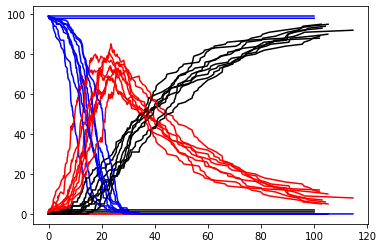

In [6]:
rg = Generator(PCG64(4))  # Initialize bit generator (here PCG64) with seed

#--- Simulation parameters: ---
beta   = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Degree of nodes
N      = 100   # Number of nodes
T      = 100

number_of_simulations = 10

G0 = nx.random_regular_graph(d=k, n=N)

X_array = []

for q in range(number_of_simulations):
    G = G0.copy()

    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = first_reaction_method_SIR_graph_linear(G, beta, mu, T)

    X_array.append(X_t)

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_) for X_,c_ in zip(X_t[1:],colors)]

#ax.axis([0,T,0,N])



###

In [7]:
#=============================================================================
# Parameters for plots:
#=============================================================================
params = {'legend.fontsize': 6,
          'legend.handleheight': 1,
          'legend.handlelength': 2,
          'xtick.labelsize': 6,
          'ytick.labelsize': 6,
          'axes.labelsize': 8}
plt.rcParams.update(params)
# Symbol size:
ms=3


### 

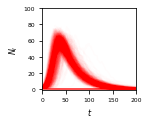

In [8]:
rg = Generator(PCG64(4))  # Initialize bit generator (here PCG64) with seed

#--- Simulation parameters: ---
beta   = 0.06   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Degree of nodes
N      = 100   # Number of nodes
T      = 200

number_of_simulations = 1000

G0 = nx.random_regular_graph(d=k, n=N)

X_array = []

for q in range(number_of_simulations):
    G = G0.copy()

    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = first_reaction_method_SIR_graph_linear(G, beta, mu, T)

    X_array.append(X_t)

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']
alpha = 0.01

fig = plt.figure(figsize=(3.375/2.,3./2.))
ax  = plt.subplot()

for X_t in X_array:
    ax.plot(X_t[0],X_t[2],c=colors[1],alpha=alpha) 
#    [ax.plot(X_t[0],X_,c=c_,alpha=alpha) for X_,c_ in zip(X_t[1:],colors)]

ax.axis([0,T,-1,N])
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$N_I$')

fig.savefig('N_t,first-reaction.pdf',format='pdf',dpi=300)


## Test speed

In [9]:
nx.set_node_attributes(G0, 'state', 0)
for i,state in enumerate(states):
    G0.nodes[i]['state'] = state       
    
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed

In [10]:
%%timeit

G1 = G0.copy()
first_reaction_method_SIR_graph_linear(G1, beta, mu, T)

31.1 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## ER graph 

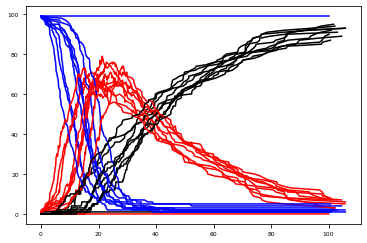

In [11]:
#--- Simulation parameters: ---
beta = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

Q = 10

G0 = nx.gnm_random_graph(n=N, m=k*N/2)

X_array = []

for q in range(Q):
    G = G0.copy()

    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = first_reaction_method_SIR_graph_linear(G, beta, mu, T)

    X_array.append(X_t)
    
#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_) for X_,c_ in zip(X_t[1:],colors)]

##  BA graph

(0.0, 100.0, 0.0, 100.0)

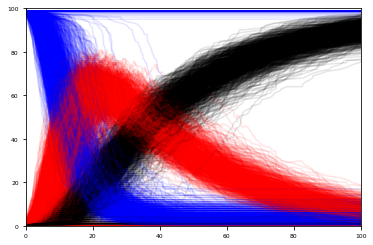

In [12]:
#--- Simulation parameters: ---
beta   = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 4     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

Q = 1000

G0 = nx.barabasi_albert_graph(n=N, m=int(k/2))

X_array = []

for q in range(Q):
    G = G0.copy()

    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = first_reaction_method_SIR_graph_linear(G, beta, mu, T)

    X_array.append(X_t)

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_,alpha=0.1) for X_,c_ in zip(X_t[1:],colors)]

ax.axis([0,T,0,N])